This notebook focuses on trying to find a way to segment cells within organoids properly.
The end goals is to segment cell and extract morphology features from cellprofiler.
These masks must be imported into cellprofiler to extract features.

## import libraries 

In [1]:
import argparse
import multiprocessing
import pathlib
from multiprocessing import Pool

import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import pandas as pd
import skimage
import tifffile
import tqdm
from skimage import io

# check if in a jupyter notebook
try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

## parse args and set paths

In [2]:
if not in_notebook:
    print("Running as script")
    # set up arg parser
    parser = argparse.ArgumentParser(description="Segment the nuclei of a tiff image")

    parser.add_argument(
        "--input_dir",
        type=str,
        help="Path to the input directory containing the tiff images",
    )
    parser.add_argument(
        "--compartment",
        type=str,
        default="none",
        help="Compartment to segment. Options are 'nuclei', 'cell', and 'organoid'",
    )
    parser.add_argument(
        "--window_size",
        type=int,
        default=5,
        help="Window size for the median filter",
    )

    args = parser.parse_args()
    input_dir = pathlib.Path(args.input_dir).resolve(strict=True)
    compartment = args.compartment
    window_size = args.window_size
else:
    print("Running in a notebook")
    input_dir = pathlib.Path("../../data/NF0014/normalized_z/C4-2/").resolve(
        strict=True
    )
    compartment = "organoid"
    window_size = 5

mask_path = pathlib.Path(f"../processed_data/{input_dir.stem}").resolve()
mask_path.mkdir(exist_ok=True, parents=True)

if compartment == "nuclei":
    mask_file_path = pathlib.Path(mask_path / "nuclei_masks.tiff").resolve()
    reconstruction_dict_path = pathlib.Path(
        mask_path / "nuclei_reconstruction_dict.npy"
    ).resolve(strict=True)
    distance_threshold = 20
elif compartment == "cell":
    mask_file_path = pathlib.Path(mask_path / "cell_masks.tiff").resolve()
    reconstruction_dict_path = pathlib.Path(
        mask_path / "cell_reconstruction_dict.npy"
    ).resolve(strict=True)
    distance_threshold = 50
elif compartment == "organoid":
    mask_file_path = pathlib.Path(mask_path / "organoid_masks.tiff").resolve()
    reconstruction_dict_path = pathlib.Path(
        mask_path / "organoid_reconstruction_dict.npy"
    ).resolve(strict=True)
    distance_threshold = 100
else:
    raise ValueError(
        "Invalid compartment, please choose 'nuclei', 'cell', or 'organoid'"
    )

Running in a notebook


## Set up images, paths and functions

In [3]:
def euclidian_2D_distance(coord_set_1: tuple, coord_set_2: tuple) -> float:
    """
    This function calculates the euclidian distance between two sets of coordinates (2D)

    sqrt((x1 - x2)^2 + (y1 - y2)^2)

    Parameters
    ----------
    coord_set_1 : tuple
        The first set of coordinates (x, y)
    coord_set_2 : tuple
        The second set of coordinates (x, y)

    Returns
    -------
    float
        The euclidian distance between the two sets of coordinates
    """
    return np.sqrt(
        (coord_set_1[0] - coord_set_2[0]) ** 2 + (coord_set_1[1] - coord_set_2[1]) ** 2
    )

In [4]:
def check_coordinate_inside_box(
    coord: tuple,
    box: tuple,
) -> bool:
    """
    This function checks if a coordinate is inside a box

    Parameters
    ----------
    coord : tuple
        The coordinate to check (y, x)
    box : tuple
        The box to check against [y_min, x_min, y_max, x_max]

    Returns
    -------
    bool
        True if the coordinate is inside the box, False otherwise
    """
    # check if coords and box are valid
    if not isinstance(coord, tuple):
        raise TypeError("coord must be a tuple")
    if not isinstance(box, tuple):
        raise TypeError("box must be a list")
    if not len(box) == 4:
        raise ValueError("box must be a list of length 4")
    if not len(coord) == 2:
        raise ValueError("coord must be a tuple of length 2")

    y_coord = coord[0]
    x_coord = coord[1]

    y_min = box[0]
    x_min = box[1]
    y_max = box[2]
    x_max = box[3]

    if x_coord >= x_min and x_coord <= x_max and y_coord >= y_min and y_coord <= y_max:
        return True
    else:
        return False


def get_larger_bbox(bbox1: tuple, bbox2: tuple) -> tuple:
    """
    This function returns the larger of two bounding boxes

    Parameters
    ----------
    bbox1 : tuple
        The first bounding box [y_min, x_min, y_max, x_max]
    bbox2 : tuple
        The second bounding box [y_min, x_min, y_max, x_max]

    Returns
    -------
    tuple
        A tuple of the larger bounding box [y_min, x_min, y_max, x_max]
    """
    # check if boxes are valid
    if not isinstance(bbox1, tuple):
        raise TypeError("bbox1 must be a tuple")
    if not isinstance(bbox2, tuple):
        raise TypeError("bbox2 must be a tuple")
    if not len(bbox1) == 4:
        raise ValueError("bbox1 must be a list of length 4")
    if not len(bbox2) == 4:
        raise ValueError("bbox2 must be a list of length 4")

    bbox1_area = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    bbox2_area = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])
    if bbox1_area >= bbox2_area:
        return bbox1
    elif bbox2_area >= bbox1_area:
        return bbox2

In [5]:
image_extensions = {".tif", ".tiff"}
files = sorted(input_dir.glob("*"))
files = [str(x) for x in files if x.suffix in image_extensions]
# get the nuclei image
for f in files:
    if compartment == "nuclei" and "405" in f:
        imgs = io.imread(f)
    elif compartment == "cell" and "555" in f:
        imgs = io.imread(f)
    elif compartment == "organoid" and "488" in f:
        imgs = io.imread(f)
imgs = np.array(imgs)
original_imgs = imgs.copy()
original_z_slice_count = len(imgs)
print("number of z slices in the original image:", original_z_slice_count)

number of z slices in the original image: 33


In [6]:
reconstruction_dict = np.load(reconstruction_dict_path, allow_pickle=True).item()

## Reverse the sliding window max projection

In [7]:
class DecoupleAndReconstructMasks:
    """
    This class is used to decouple and reconstruct masks from a stack of segmented masks
    1. Extract unique masks from a stack of segmented masks
    2. Decouple masks based on xy coordinates
    3. Reconstruct masks based on xy coordinates

    """

    def __init__(self, reconstruction_dict_partial: dict, visualize: bool = False):
        """
        Initialize the DecoupleAndReconstructMasks class

        Parameters
        ----------
        reconstruction_dict_partial : dict
            Partial reconstruction dict that contains mask identities of a stack of segmented masks
            from a sliding window decomposition
        visualize : bool, optional
            Whether to visualize the reconstructed masks
        """
        self.image_stack = reconstruction_dict_partial
        self.visualize = visualize

    def extract_unique_masks(self):
        mask_indices_dict = {
            "unique_mask": [],
            "mask_indices": [],
            "psuedo_slice": [],
            "y_x_coords": [],
            "bbox": [],
        }
        # find each unqiue mask identity via pixel value
        unique_masks = np.unique(self.image_stack)
        # loop through each unique mask identity
        # drop the backgound as a mask identity
        unique_masks = unique_masks[unique_masks != 0]
        for unique_mask in unique_masks:
            # loop through each mask image
            for psuedo_slice in range(len(self.image_stack)):
                # find where the unique mask identity is in the mask image
                tmp_image = self.image_stack[psuedo_slice]
                # get only the unique mask
                image_for_coordinates = np.array(
                    tmp_image == unique_mask, dtype=np.uint8
                )
                mask_indices = np.where(tmp_image == unique_mask)
                # if the mask identity is in the mask image
                mask_indices_dict["unique_mask"].append(unique_mask)
                mask_indices_dict["mask_indices"].append(mask_indices)
                mask_indices_dict["psuedo_slice"].append(psuedo_slice)
                c = skimage.measure.regionprops(image_for_coordinates)
                for property in c:
                    centroid = property.centroid
                    bbox = property.bbox
                    mask_indices_dict["y_x_coords"].append(centroid)
                    mask_indices_dict["bbox"].append(bbox)
                if len(mask_indices_dict["y_x_coords"]) < len(
                    mask_indices_dict["mask_indices"]
                ):
                    mask_indices_dict["y_x_coords"].append(None)
                    mask_indices_dict["bbox"].append(None)
        self.unique_masks_df = pd.DataFrame(mask_indices_dict)

    def decouple_masks(self):
        # group each index into a dict of dicts based on if the xy coordinates are within a certain distance of each other
        # and if the x_y coordinates are within the bbox of the other coordinates
        output_dict = {
            "group_index": [],
            "df_indices": [],
            "index_comparison": [],
            "mask_indices": [],
            "psuedo_slice": [],
            "y_x_coords": [],
            "bbox": [],
            "area": [],
        }
        if self.unique_masks_df["psuedo_slice"].nunique() > 2:
            for i in range(len(self.unique_masks_df)):

                # get the x_y coordinates and bbox of the current index
                current_xy = self.unique_masks_df["y_x_coords"][i]
                current_bbox = self.unique_masks_df["bbox"][i]
                # if the x_y coordinates are not None
                if current_xy is not None:
                    # loop through the rest of the indices
                    for j in range(len(self.unique_masks_df)):
                        if i != j:
                            if f"{i},{j}" not in output_dict["index_comparison"]:
                                if f"{j},{i}" not in output_dict["index_comparison"]:
                                    # get the x_y coordinates and bbox of the other index
                                    other_xy = self.unique_masks_df["y_x_coords"][j]
                                    other_bbox = self.unique_masks_df["bbox"][j]
                                    # if the x_y coordinates are not None
                                    if other_xy is not None:
                                        distance = euclidian_2D_distance(
                                            current_xy, other_xy
                                        )
                                        if distance < distance_threshold:
                                            # check which bounding box has the larger area
                                            if (
                                                get_larger_bbox(
                                                    current_bbox, other_bbox
                                                )
                                                == current_bbox
                                            ):
                                                coordinate_inside_box = (
                                                    check_coordinate_inside_box(
                                                        other_xy, current_bbox
                                                    )
                                                )
                                                if coordinate_inside_box:
                                                    output_dict["df_indices"].append(i)
                                                    output_dict["mask_indices"].append(
                                                        self.unique_masks_df[
                                                            "mask_indices"
                                                        ][i]
                                                    )
                                            elif (
                                                get_larger_bbox(
                                                    current_bbox, other_bbox
                                                )
                                                == other_bbox
                                            ):
                                                coordinate_inside_box = (
                                                    check_coordinate_inside_box(
                                                        current_xy, other_bbox
                                                    )
                                                )
                                                if coordinate_inside_box:
                                                    output_dict["df_indices"].append(j)
                                                    output_dict["mask_indices"].append(
                                                        self.unique_masks_df[
                                                            "mask_indices"
                                                        ][j]
                                                    )
                                            else:
                                                coordinate_inside_box = False
                                            # check if the x_y coordinates are within the bbox of the other coordinates
                                            if coordinate_inside_box:
                                                # add the indices to the output dict
                                                output_dict["group_index"].append(i)
                                                output_dict["psuedo_slice"].append(
                                                    self.unique_masks_df[
                                                        "psuedo_slice"
                                                    ][i]
                                                )
                                                output_dict["y_x_coords"].append(
                                                    other_xy
                                                )
                                                output_dict["bbox"].append(other_bbox)
                                                mask_array = self.unique_masks_df[
                                                    "mask_indices"
                                                ][j]
                                                # get the area of the mask
                                                mask_array = np.array(mask_array)
                                                area = (
                                                    mask_array.shape[0]
                                                    * mask_array.shape[1]
                                                )
                                                output_dict["area"].append(area)
                                                output_dict["index_comparison"].append(
                                                    f"{i},{j}"
                                                )
        # for the first and last slice where there will be stacking and consensus is not needed
        else:
            for i in range(len(self.unique_masks_df)):
                output_dict["group_index"].append(i)
                output_dict["df_indices"].append(i)
                output_dict["mask_indices"].append(
                    self.unique_masks_df["mask_indices"][i]
                )
                output_dict["psuedo_slice"].append(
                    self.unique_masks_df["psuedo_slice"][i]
                )
                output_dict["y_x_coords"].append(self.unique_masks_df["y_x_coords"][i])
                output_dict["bbox"].append(self.unique_masks_df["bbox"][i])
                output_dict["index_comparison"].append(f"{i},{i}")
                mask_array = self.unique_masks_df["mask_indices"][i]
                # get the area of the mask
                mask_array = np.array(mask_array)
                area = mask_array.shape[0] * mask_array.shape[1]
                output_dict["area"].append(area)

        self.output_df = pd.DataFrame(output_dict)

    def reconstruct_masks(self):
        dict_of_masks = {}
        # get all unique group indices
        group_indices = np.unique(self.output_df["group_index"])
        for index in group_indices:
            df = self.output_df.loc[self.output_df["group_index"] == index]
            if len(df) > 0:
                # keep the row with the largest area
                largest_area_index = df["area"].idxmax()
                largest_area_row = df.loc[largest_area_index]
                consensus_mask = largest_area_row["mask_indices"]

                dict_of_masks[index] = consensus_mask

        # get the dimensions of the original image
        self.reassembled_masks = np.zeros(
            (original_imgs.shape[1], original_imgs.shape[2]), dtype=np.uint8
        )
        # loop through each mask in the dict
        if len(dict_of_masks) <= 2:
            self.reassembled_masks[dict_of_masks[index]] = 1
        else:
            for index, mask in dict_of_masks.items():
                # set the pixels in the reassembled masks to the index value
                self.reassembled_masks[mask] = index

    def visualize_reconstructed_masks(self):
        # visualize the reassembled masks
        plt.figure(figsize=(5, 5))
        plt.imshow(self.reassembled_masks)
        plt.show()

    def run_reconstruction(self):
        self.extract_unique_masks()
        self.decouple_masks()
        self.reconstruct_masks()

        if self.visualize:
            self.visualize_reconstructed_masks()
        return self.reassembled_masks

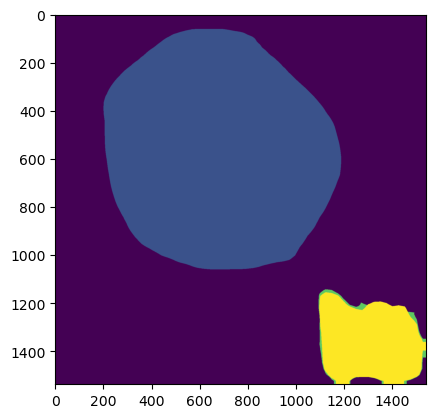

In [15]:
decoupling = DecoupleAndReconstructMasks(reconstruction_dict[3], visualize=False)
mask = decoupling.run_reconstruction()
plt.imshow(mask)

In [44]:
decoupling.unique_masks_df
decoupling.output_df

,group_index,df_indices,index_comparison,mask_indices,psuedo_slice,y_x_coords,bbox,area
0,0,0,"0,1","([59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, ...",0,"(573.3729968986336, 676.9249945664269)","(60, 202, 1059, 1193)",1536742
1,0,0,"0,2","([59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, ...",0,"(573.6097363321393, 677.693059552006)","(62, 201, 1061, 1188)",1532610
2,1,1,"1,2","([60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, ...",1,"(573.6097363321393, 677.693059552006)","(62, 201, 1061, 1188)",1532610
3,3,4,"3,4","([1143, 1144, 1144, 1144, 1144, 1144, 1144, 11...",0,"(1361.9055198333635, 1300.9398055907745)","(1143, 1094, 1537, 1540)",265008
4,3,5,"3,5","([1156, 1156, 1156, 1156, 1156, 1156, 1156, 11...",0,"(1361.0263665146813, 1303.9309717523747)","(1156, 1097, 1537, 1540)",258358
5,4,4,"4,5","([1143, 1144, 1144, 1144, 1144, 1144, 1144, 11...",1,"(1361.0263665146813, 1303.9309717523747)","(1156, 1097, 1537, 1540)",258358


In [ ]:
decoupled_masks = {
    "z_slice": [],
    "mask": [],
}
for zslice in tqdm.tqdm(range(len(reconstruction_dict))):
    decoupling = DecoupleAndReconstructMasks(
        reconstruction_dict[zslice], visualize=False
    )
    mask = decoupling.run_reconstruction()
    decoupled_masks["z_slice"].append(zslice)
    decoupled_masks["mask"].append(mask)

# conver the masks to a numpy array
masks = np.array(decoupled_masks["mask"])

  3%|▎         | 1/33 [00:00<00:06,  5.04it/s]

0
   group_index  df_indices index_comparison  \
0            0           0              0,0   
1            1           1              1,1   

                                        mask_indices  psuedo_slice  \
0  ([59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, ...             0   
1  ([1146, 1146, 1146, 1146, 1146, 1146, 1146, 11...             0   

                                 y_x_coords                      bbox     area  
0    (587.1851196919285, 658.1412584238276)     (59, 174, 1061, 1186)  1603784  
1  (1368.4774015054586, 1294.9601369202906)  (1146, 1095, 1537, 1526)   240724  
[0 1]
1
Empty DataFrame
Columns: [group_index, df_indices, index_comparison, mask_indices, psuedo_slice, y_x_coords, bbox, area]
Index: []
[]


UnboundLocalError: cannot access local variable 'index' where it is not associated with a value

In [19]:
decoupling.output_df

,group_index,df_indices,index_comparison,mask_indices,psuedo_slice,y_x_coords,bbox,area


In [9]:
# save the masks to a tiff file
tifffile.imwrite(mask_file_path, masks)

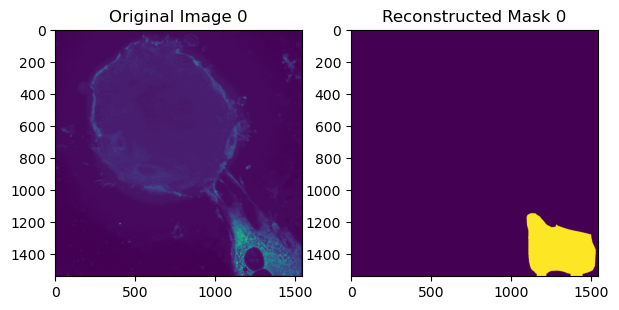

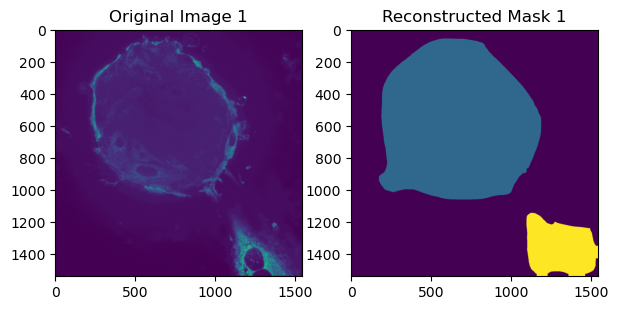

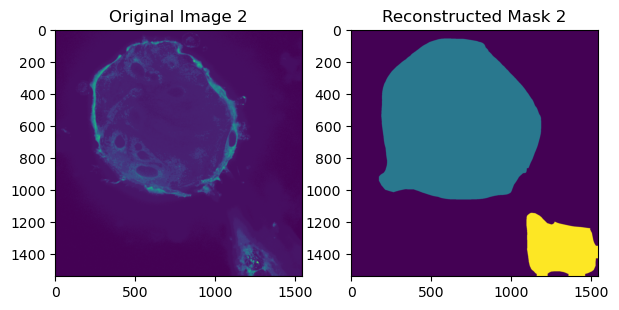

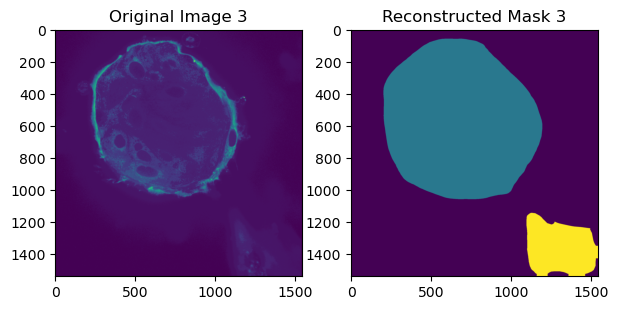

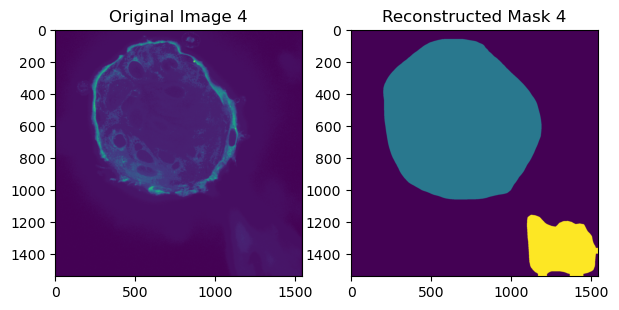

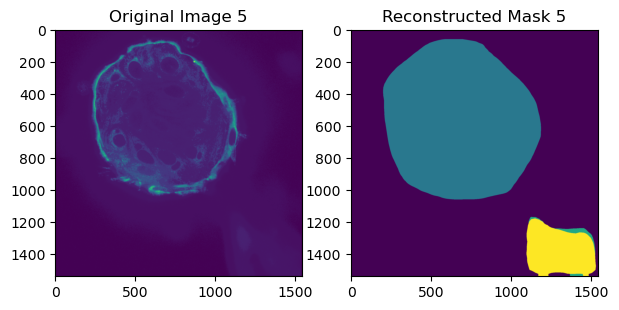

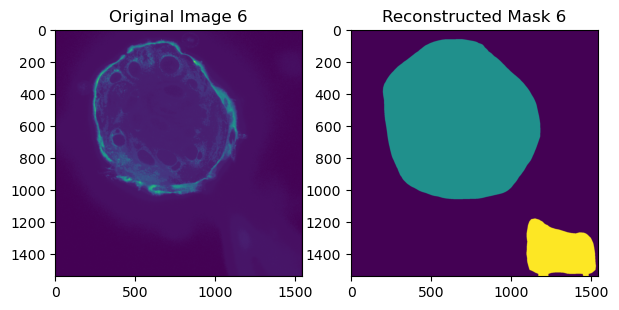

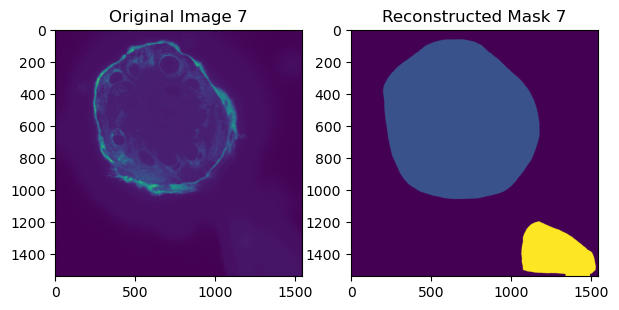

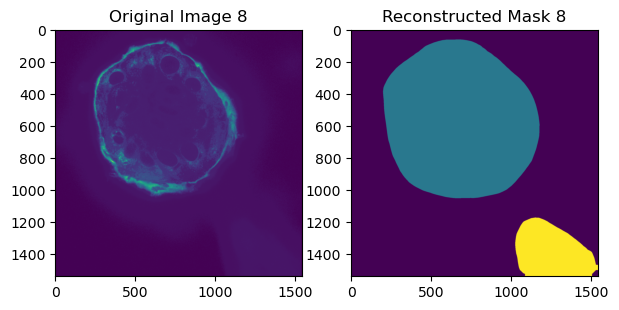

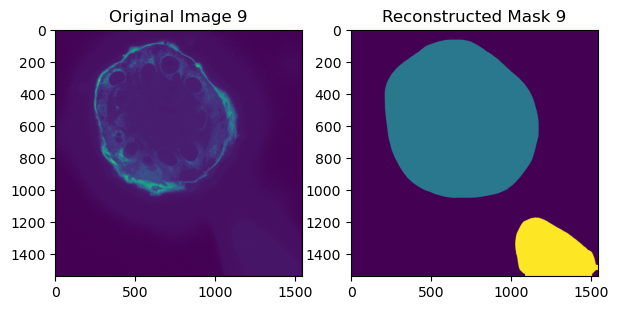

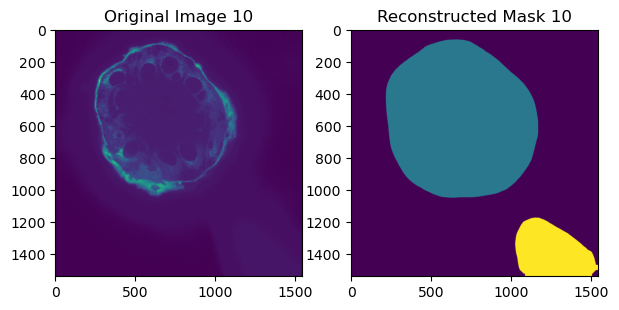

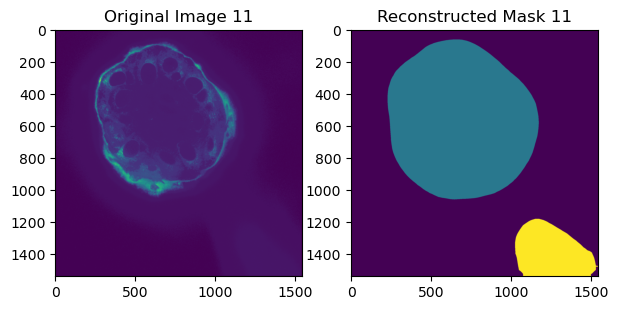

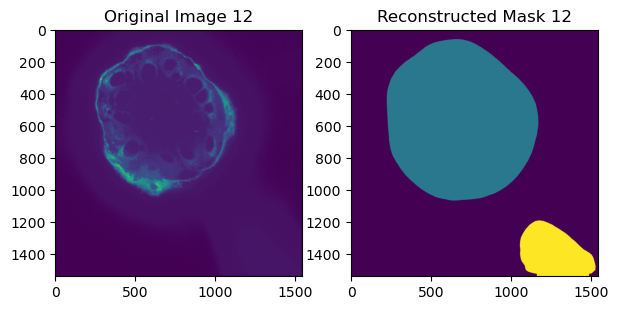

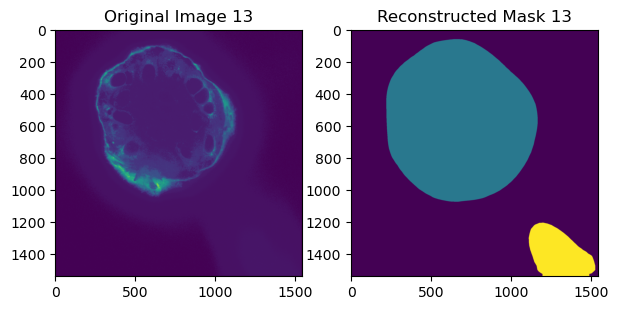

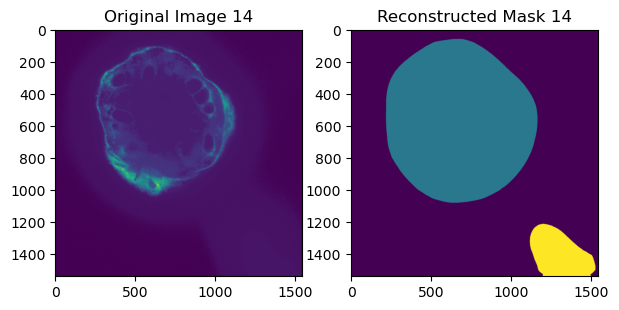

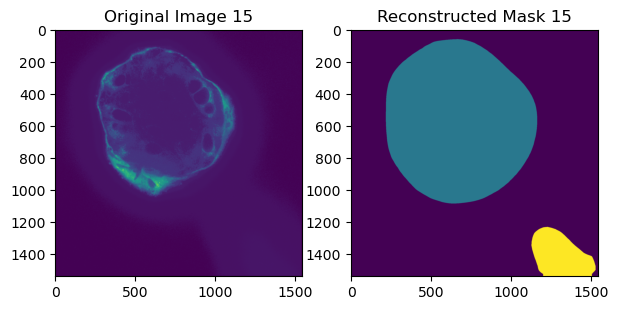

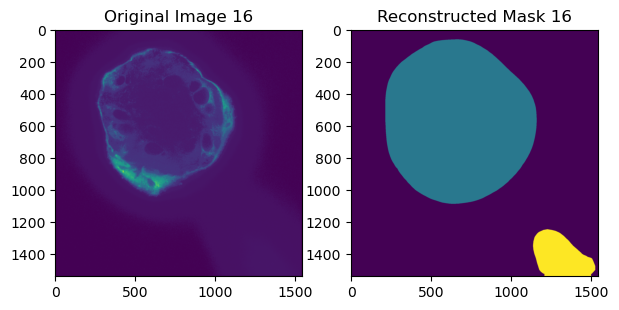

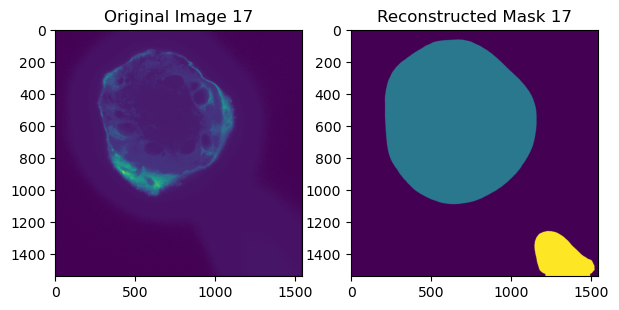

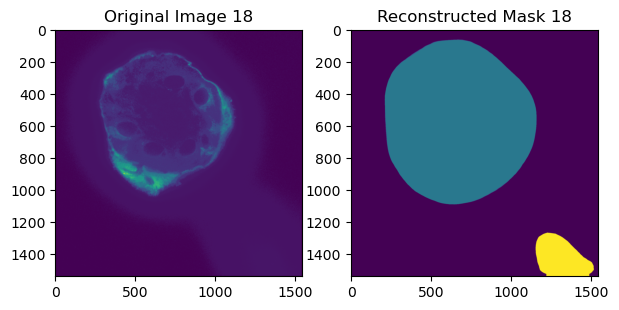

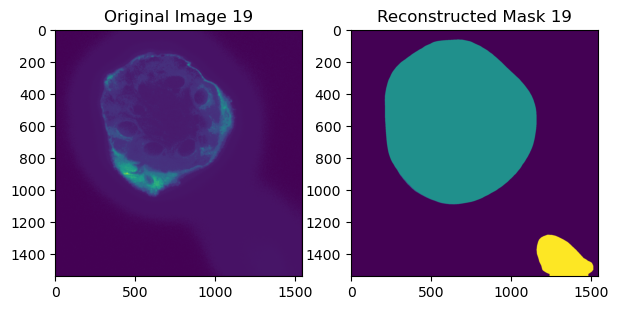

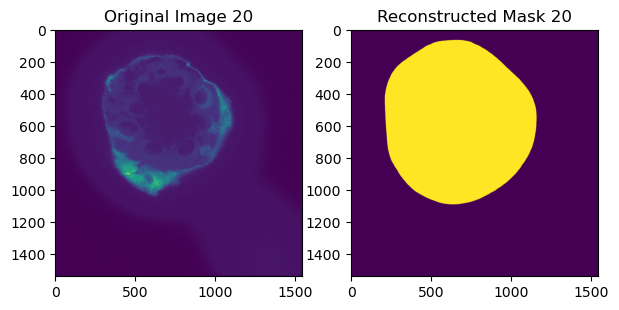

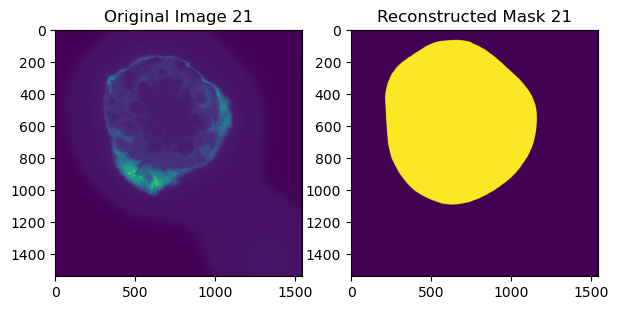

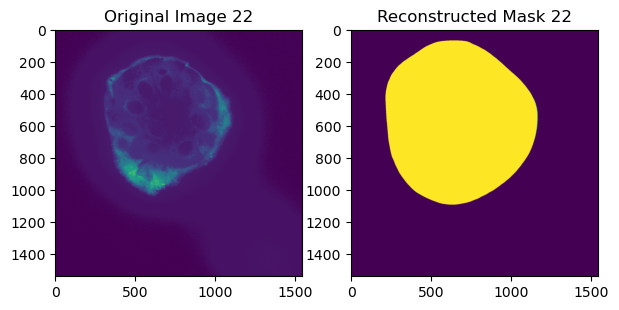

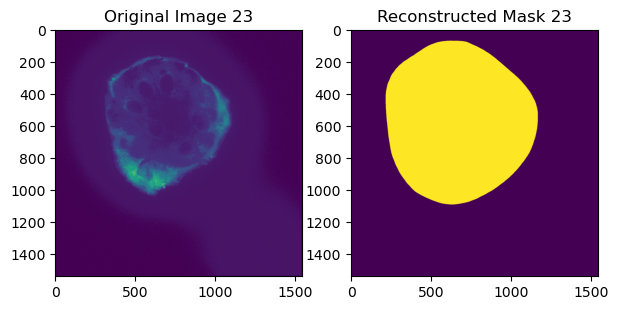

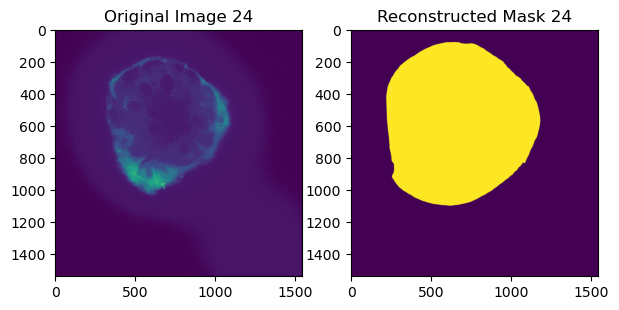

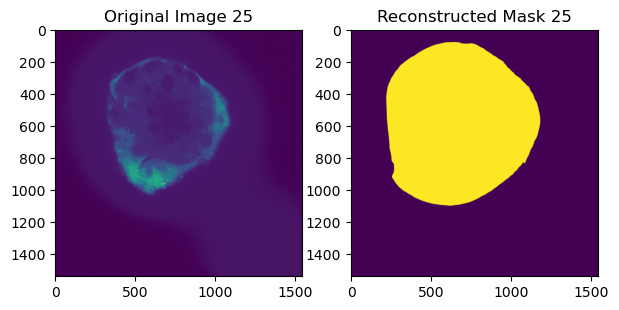

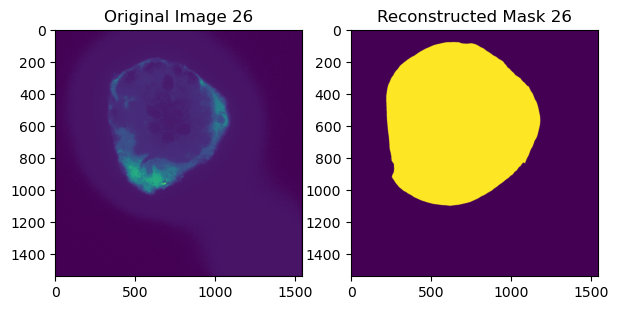

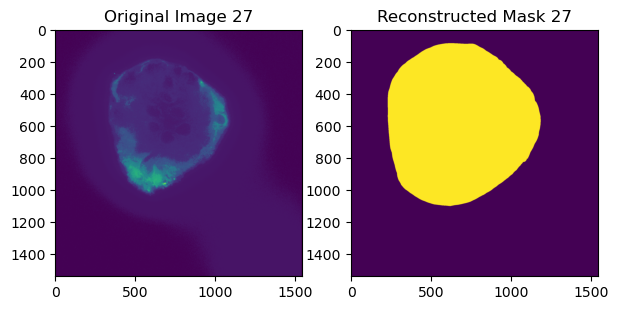

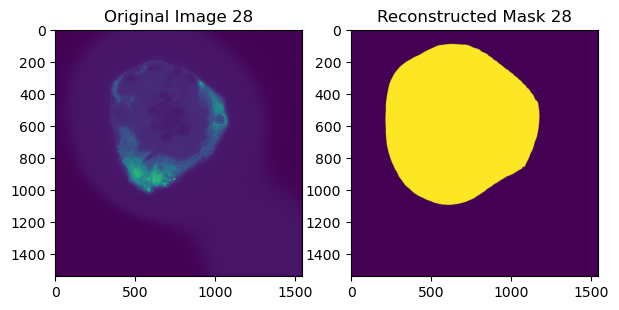

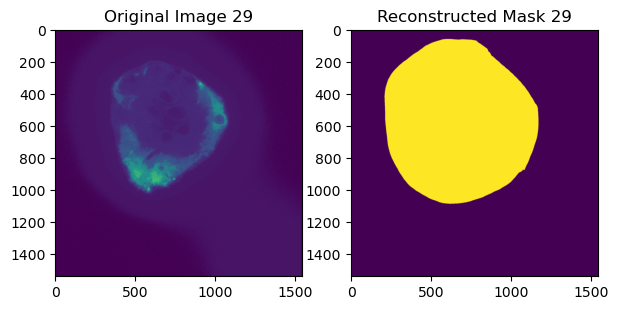

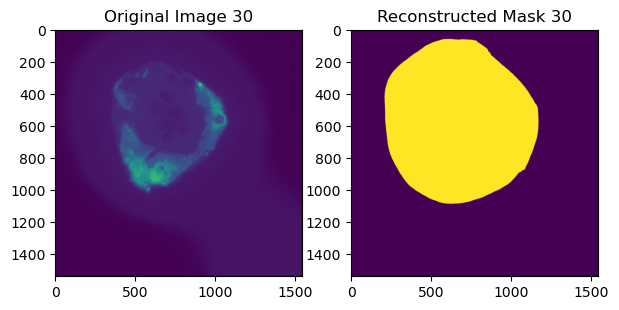

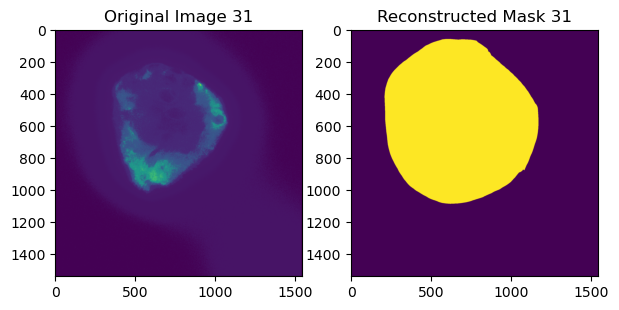

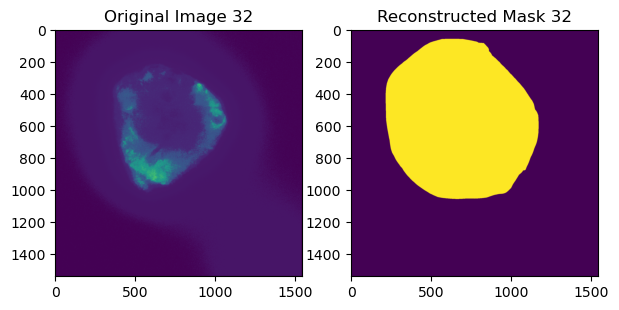

In [10]:
if in_notebook:
    for i in range(masks.shape[0]):
        plt.figure(figsize=(7, 7))
        plt.subplot(1, 2, 1)
        plt.imshow(original_imgs[i])
        plt.title(f"Original Image {i}")
        plt.subplot(1, 2, 2)
        plt.imshow(masks[i])
        plt.title(f"Reconstructed Mask {i}")
        plt.show()